## Time series project (IBM through coursera): Analysis of daily count of visitors on a website

### import the libraries and the data

In [2]:
# Setup
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sys, os
os.chdir('C:/Users/julia/OneDrive/Desktop/Coursera/time series Python/project')
import warnings
warnings.simplefilter(action='ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from datetime import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
# load data
temperaturestrain = pd.read_csv('./DailyDelhiClimateTrain.csv')
temperaturestest = pd.read_csv('./DailyDelhiClimateTest.csv')
temperatures = pd.concat([temperaturestrain, temperaturestest])
temperatures['date'] = pd.to_datetime(temperatures['date'])
temperatures

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


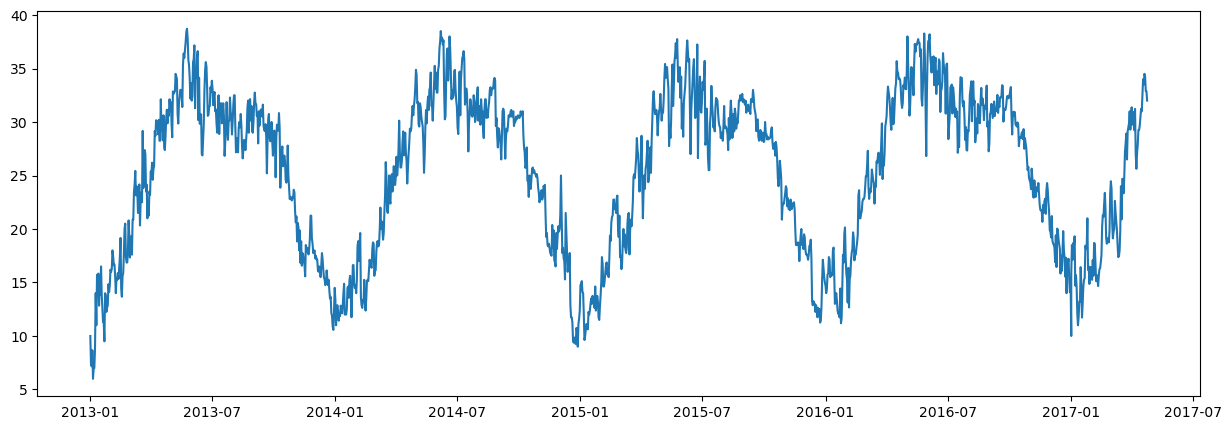

In [4]:
dates = temperatures['date'].values
temperature  = temperatures['meantemp'].values
plt.figure(figsize=(15,5))
plt.plot(dates, temperature)

In [5]:
# splitting the data into train and test sets
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """
    
    return df[series_name][-(24*n_days):] 

def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_hours, 
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours] 
    test_y = test[input_hours:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

In [6]:
series_days = 80
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(temperatures, 'meantemp', series_days, 
                         input_hours, test_hours))

In [7]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

In [8]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

1/1 [==============================] - 0s 17ms/step


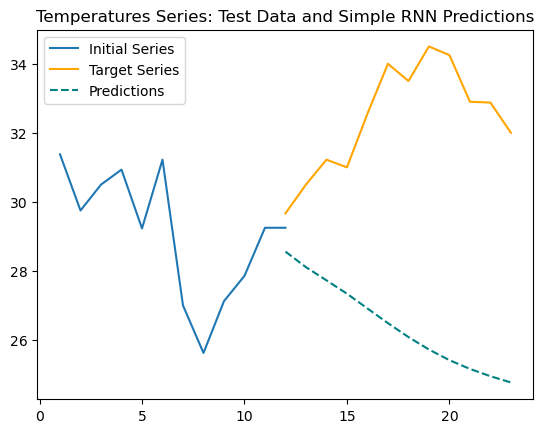

In [25]:
np.random.seed(2023)
modelrnn = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X_init, test_y, modelrnn,
                 'Temperatures Series: Test Data and Simple RNN Predictions')

In [10]:
modelrnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30)                960       
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 29ms/step


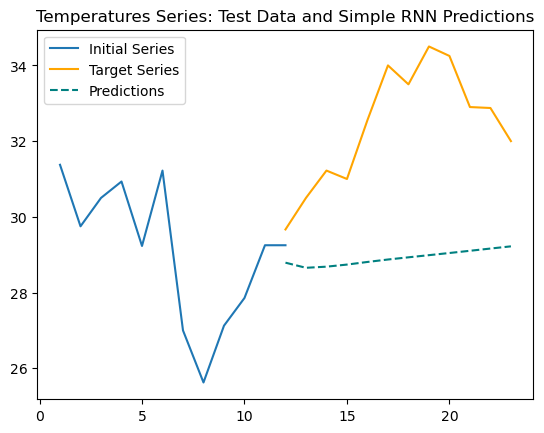

In [27]:
modelrnn = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X_init, test_y, modelrnn,
                 'Temperatures Series: Test Data and Simple RNN Predictions')

array([[[10.        ],
        [ 7.4       ],
        [ 7.16666667],
        ...,
        [11.        ],
        [15.71428571],
        [14.        ]],

       [[ 8.66666667],
        [ 6.        ],
        [ 7.        ],
        ...,
        [15.83333333],
        [12.83333333],
        [14.71428571]],

       [[ 7.        ],
        [ 8.85714286],
        [14.        ],
        ...,
        [13.83333333],
        [16.5       ],
        [13.83333333]],

       ...,

       [[17.44444444],
        [18.        ],
        [19.875     ],
        ...,
        [27.25      ],
        [28.        ],
        [28.91666667]],

       [[24.        ],
        [20.9       ],
        [24.69230769],
        ...,
        [26.5       ],
        [29.1       ],
        [29.5       ]],

       [[24.66666667],
        [23.33333333],
        [25.        ],
        ...,
        [29.88888889],
        [31.        ],
        [29.28571429]]])

In [28]:
# Train a LSTM
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

1/1 [==============================] - 0s 20ms/step


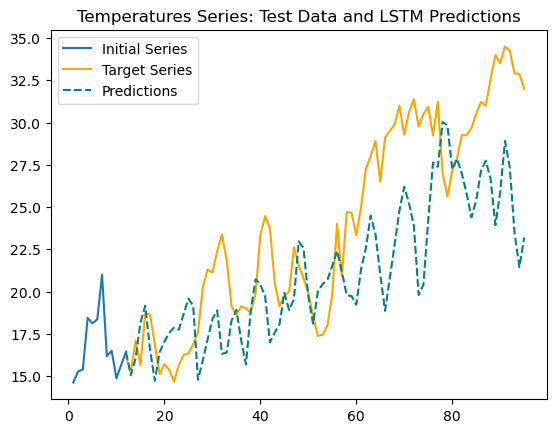

In [30]:
series_days = 50 
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(temperatures, 'meantemp', series_days, 
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000) 

predict_and_plot(test_X_init, test_y, model, 
                 'Temperatures Series: Test Data and LSTM Predictions')

1/1 [==============================] - 0s 18ms/step


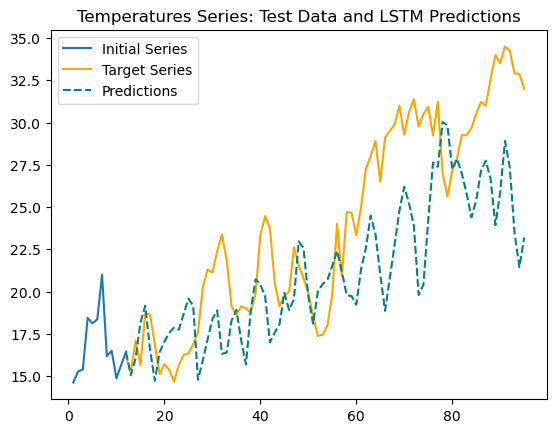

In [37]:
predict_and_plot(np.concatenate((train_X.reshape(-1), test_X_init)), test_y, model, 
                 'Temperatures Series: Test Data and LSTM Predictions')

In [40]:
len(np.concatenate((train_X.reshape(-1), test_X_init)))

4380

In [190]:
def winnowing(series, target, prev_known,
               W_in=1, W_out=1):
    n = len(series[0])
    dataX = NAN*np.ones((n,W_in,len(series)))
    if W_out==1:
        dataY = series[target].copy()
    else:
        dataY = NAN*np.ones((n,W_out))
        dataY[:,0] = series[target].copy()
        for i in range(1,W_out):
            dataY[:-i,i] = dataY[i:,0].copy()
    
    for i in range(n):
        for j,s in enumerate(prev_known):
            int_s = int(s) 
            ini_X = max([0,W_in-i-int_s])
            dataX[i, ini_X:,j] = \
            series[j][max([0,i-W_in+int_s]):min([n,i+int_s])]
    
    return dataX, dataY

def info_winnowing(X,Y,names_series,name_target,times=None):
    c0  = '\033[1m'  
    c1  = '\033[0m'  
    W_in = X.shape[1]
    if len(Y.shape)==1:
        W_out = 1
    else:
        W_out = Y.shape[1]
    print(len(X), "windows created \n")
    print("X.shape={}".format(X.shape)," Y.shape={}".format(Y.shape),"\n")
    for t in range(len(X)):
        print(c0,"Window %d:"%t, c1)
        if times is None:
            names_ts = ["t="+str(t+i-W_in) for i in range(W_in)]
            names_ts_pred = ["t="+str(t+i) for i in range(W_out)]
        else:
            times = list(times)
            if (t-W_in)<0:
                names_ts = ["?"+str(i) for i in range(W_in-t)] + times[:t]
            else:
                names_ts = times[(t-W_in):t]
            if (t+W_out-1)>=len(times):
                names_ts_pred = times[t:] + ["?"+str(i) for i in range(W_out-(len(times)-t))]
            else:
                names_ts_pred = times[t:(t+W_out)]
        aux1 = pd.DataFrame(X[t].T,columns=names_ts,index=names_series)
        aux2 = pd.DataFrame([Y[t]],columns=names_ts_pred,
                            index=[name_target])
        if W_out==1:
            my_dfs_display((aux1,aux2),
                           ("X[{}].shape={}".format(t,X[t].shape),
                            "Y[{}]={}".format(t,Y[t])))
        else:
            my_dfs_display((aux1,aux2),
                           ("X[{}].shape={}".format(t,X[t].shape),
                            "Y[{}].shape={}".format(t,Y[t].shape)))
            
def my_dfs_display(dfs,names):
    df_styler = []
    for df,n in zip(dfs,names):
        df_styler.append(df.style.set_table_attributes("style='display:inline'").\
                         set_caption(n))
    display_html(df_styler[0]._repr_html_()+"__"+df_styler[1]._repr_html_(),
                 raw=True)

In [191]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from IPython.display import display_html

In [192]:
lookback = 6  # Window_in
prev_known = [False]
NAN = np.NAN
series = 'meantemp'
X, y = winnowing(series, target=0, prev_known=prev_known,
                  W_in=lookback)

print(X.shape, np.shape(y))

AttributeError: 'str' object has no attribute 'copy'

In [41]:
# Setup
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sys, os
os.chdir('C:/Users/julia/OneDrive/Desktop/Coursera/time series Python/project')
import warnings
warnings.simplefilter(action='ignore')
import sys
!{sys.executable} -m pip install pmdarima
import pmdarima as pm

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [42]:
# load data and convert to datetime
train_temp = pd.read_csv('./DailyDelhiClimateTrain.csv', 
                           skipfooter=2, 
                           infer_datetime_format=True, 
                           header=0, 
                           index_col=0, engine='python')
test_temp = pd.read_csv('./DailyDelhiClimateTest.csv', 
                           skipfooter=2, 
                           infer_datetime_format=True, 
                           header=0, 
                           index_col=0, engine='python')
train_temp.index = pd.to_datetime(train_temp.index)
test_temp.index = pd.to_datetime(test_temp.index)
temp_all = pd.concat([train_temp, test_temp])
temp_all.index = pd.to_datetime(temp.index)
temp_all

NameError: name 'temp' is not defined

In [ ]:
# define helper plot function for visualization
def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

In [ ]:
# helper plot for temperatures
plt.figure(figsize=(15,5))
plots(temp_all.meantemp, lags=24);
# open Duke guide for visual
# we note a 12-period cycle (yearly) with suspension bridge design, so must use SARIMA

In [ ]:


# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(train_temp.meantemp, 
                                order=(1,0,0), 
                                seasonal_order=(0,1,1,12), 
                                trend='c').fit()
sar.summary()

In [ ]:
# plot resids
plt.figure(figsize=(15,5))
plots(sar.resid[sar.loglikelihood_burn:], lags=12);

In [ ]:
# plot residual diagnostics
sar.plot_diagnostics(lags=12,figsize = (20,10),);

In [ ]:
len(test_temp)

In [ ]:
# plot predictions
pd.plotting.register_matplotlib_converters()
#use model.predict() start and end in relation to series
plt.figure(figsize=(15,5))
temp_all['forecast'] = sar.predict(start = 1460, end= 1572)  
temp_all[1000:][['meantemp', 'forecast']].plot();

In [ ]:
#Introducing another model
sar2 = sm.tsa.statespace.SARIMAX(train_temp.meantemp, 
                                order=(3,0,0), 
                                seasonal_order=(0,1,1,12), 
                                trend='c').fit()

# plot predictions
temp_all['forecast'] = sar2.predict(start = 1460, end= 1572, dynamic=False) 
plt.figure(figsize=(15,5))
plt.plot(temp_all[1000:][['meantemp', 'forecast']])
plt.grid();

In [ ]:
# can use get forecast to create a forecast object
future_fcst = sar2.get_forecast(112)
# That will have a method to pull in confidence interval 
confidence_int = future_fcst.conf_int(alpha = 0.01)
# Has an attribute to pull in predicted mean
fcst = future_fcst.predicted_mean
# Plot predictions and confidence intervals
plt.plot(temp_all.meantemp[-112:])
plt.plot(fcst)
plt.grid()

In [ ]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox',)[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]


# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(
    sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

In [ ]:
#from pyramid.arima import auto_arima
stepwise_model = pm.auto_arima(train_temp.meantemp, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

In [ ]:
#Introducing another model
sar3 = sm.tsa.statespace.SARIMAX(train_temp.meantemp, 
                                order=(2,0,1), 
                                seasonal_order=(0,0,0,12), 
                                trend='c').fit()

# plot predictions
temp_all['forecast'] = sar3.predict(start = 1460, end= 1572, dynamic=False) 
plt.figure(figsize=(15,5))
plt.plot(temp_all[1000:][['meantemp', 'forecast']])
plt.grid();

In [ ]:
from dateutil.relativedelta import relativedelta
def future_preds_df(model,series,num_months):
    pred_first = series.index.max()+relativedelta(months=1)
    pred_last = series.index.max()+relativedelta(months=num_months)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'MS')
    vals = model.predict(n_periods = num_months)
    return pd.DataFrame(vals,index = date_range_index)

preds = future_preds_df(stepwise_model,temp_all.meantemp,200)

plt.plot(temp_all.meantemp)
plt.plot(preds)



In [ ]:
stepwise_model.plot_diagnostics();

In [ ]:
print('auto-fit order: :', stepwise_model.order)
print('auto-fit seasonal_order: :', stepwise_model.seasonal_order)

In [ ]:
def cross_validate(series,horizon,start,step_size,order = (1,0,0),seasonal_order = (0,0,1,12),trend=None):
    '''
    Function to determine in and out of sample testing of arima model    
    
    arguments
    ---------
    series (seris): time series input
    horizon (int): how far in advance forecast is needed
    start (int): starting location in series
    step_size (int): how often to recalculate forecast
    order (tuple): (p,d,q) order of the model
    seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    
    Returns
    -------
    DataFrame: gives fcst and actuals with date of prediction
    '''
    fcst = []
    actual = []
    date = []
    for i in range(start,len(series)-horizon,step_size):
        model = sm.tsa.statespace.SARIMAX(series[:i+1], #only using data through to and including start 
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=trend).fit()
        fcst.append(model.forecast(steps = horizon)[-1]) #forecasting horizon steps into the future
        actual.append(series[i+horizon]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

warnings.filterwarnings("ignore")
series = temp_all.meantemp
horizon = 112
start = 1460
step_size = 112
order = (1,0,0)
seasonal_order = (0,0,1,12)

cv1 = cross_validate(temp_all.meantemp,112,1572,12,
                    order = order,
                    seasonal_order = seasonal_order)

#example to see underpinning of cv


model = sm.tsa.statespace.SARIMAX(series[:1461], #only using data through start of 700
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=None).fit()

#end of input
series[:1461]



In [43]:
#value to predict horizon steps into the future
series[1461:1572]

NameError: name 'series' is not defined

In [44]:
# what model predicted for that date
model.forecast(112)[-1:]


AttributeError: 'Sequential' object has no attribute 'forecast'

In [45]:

cv1

NameError: name 'cv1' is not defined